# Learning Virtual Values

In this tutorial, we will extend the ideas from the [previous tutorial](learning-position-auctions.ipynb).  We will consider position auctions, like those found in paid search marketplaces, but focus on virtual value transformations rather than payment and allocation networks.

## Motivating example

Consider a three-bidder, two-slot position auction where the values for the three bidders are correlated.  There is a signal $c\sim U[0,1]$, which we intepret as a _conversion rate_.  The value of the item for bidder 1 is a random variable $v_1 = x_1 c$ where $x_1 \sim U[0,1]$, similarly for bidder 2 and bidder 3 with independent $x_i \sim U[0,1]$.

The first slot has a click-through-rate (quality) of 1.  The second slot has a click-through-rate of 0.5.  A bidder may purchase one slot only, so we can consider this a special case of a multi-item, unit-demand scenario.

## Architectures and supporting functions

In this tutorial, we will make use of Monotonic networks.

### Preliminaries

We will make heavy use of numpy, pandas, and pytorch.

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')

We will also make use of matplotlib and seaborn for visualization:

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Common components

All mechanism networks will output allocations and payments.  The allocation shape is `[batch_size, bidders]`.  The columns represent the probability that the item is allocated to the respective bidder.  The payment shape is `[batch_size, bidders]`.  Here each column represents the payment of the respective bidder.

We define a generic mechanism as follows:

In [3]:
class MechanismNet(nn.Module):
    def __init__(self, allocation_rule, payment_rule):
        super(MechanismNet, self).__init__()
        self.allocation_rule = allocation_rule
        self.payment_rule = payment_rule
        
    def forward(self, x, signals):
        allocation = self.allocation_rule(x, signals)
        return allocation, self.payment_rule(x, signals)


We define a position mechanism as a `sequential slot mechanism` as a mechanism where each slot is allocated sequentially to the remaining (non-winning) bidders.  The slot allocations and payments can be weighted with a slot-dependent factor and use a virtual value function to transform the bids and prices.

In [4]:
class SequentialSlotMechanismNet(nn.Module):
    def __init__(self, slot_mechanisms, slot_weights, virtual_net):
        super(SequentialSlotMechanismNet, self).__init__()
        assert len(slot_mechanisms) == len(slot_weights)
        self.slot_mechanisms = nn.ModuleList(slot_mechanisms)
        self.slot_weights = slot_weights
        self.virtual_net = virtual_net
        
    def forward(self, x, signals):
        virtual_bids = self.virtual_net(x, bids=x, signals=signals)
        
        allocations, virtual_payments, weights = [], [], []
        for weight, mechanism in zip(self.slot_weights, self.slot_mechanisms):
            allocation, payment = mechanism(virtual_bids, signals)
            allocations.append(allocation)
            virtual_payments.append(payment)
            weights.append(weight)
            virtual_bids = (1-allocation) * virtual_bids
            
        payments = [self.virtual_net(vp, bids=x, signals=signals, invert=True) for vp in virtual_payments]
        weighted_allocations = [a * w for a,w in zip(allocations, weights)]
        weighted_payments = [wa*p for wa,p in zip(weighted_allocations,payments)]
        return sum(weighted_allocations), sum(weighted_payments)
    

Utility can thusly be calculated by:

In [5]:
def calc_utility(bids, signals, mechanism, valuation=None, output_components=False):
    valuation = valuation if valuation is not None else bids
    allocation, payment = mechanism(bids, signals)
    if output_components:
        return allocation*valuation-payment, allocation, payment
    else:
        return allocation*valuation-payment

The `calc_utility` function will return a tensor of shape `[batch_size,bidders]`.

We now define two monotonic network class, where `Identity` is a special case that returns its inputs.

In [6]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, input, bids=None, signals=None, invert=False):
        return input
    
class Monotonic(nn.Module):
    __constants__ = ['bias']

    def __init__(self, bidders, signal_count, hidden_features, linear_functions, groups):
        super(Monotonic, self).__init__()
        self.bidders = bidders
        self.linear_functions = linear_functions
        self.groups = groups
        self.signals_bn = nn.BatchNorm1d(signal_count)
        self.linear0 = nn.ModuleList([nn.Linear(bidders + signal_count, hidden_features) for _ in range(bidders)])
        self.linear1 = nn.ModuleList([nn.Linear(hidden_features, hidden_features) for _ in range(bidders)])
        self.weights = nn.ModuleList([nn.Linear(hidden_features, linear_functions * groups) for _ in range(bidders)])
        self.biases = nn.ModuleList([nn.Linear(hidden_features, linear_functions * groups) for _ in range(bidders)])
        
    def calc_weights_and_biases(self, bidder, bids, signals):
        zero_bidder_bids = bids.index_fill(1,torch.tensor([bidder]).to(device),0)
        signals = self.signals_bn(signals)
        in0 = torch.cat((zero_bidder_bids,signals), dim=1)
        out0 = F.leaky_relu(self.linear0[bidder](in0))
        out1 = F.leaky_relu(self.linear1[bidder](out0))
        return self.weights[bidder](out1), self.biases[bidder](out1)
        
    def apply_forward_by_bidder(self, bidder, bids, signals):
        focused_bids = bids[:,bidder].unsqueeze(dim=1)
        w, b = self.calc_weights_and_biases(bidder, bids, signals)
        intermediate = torch.exp(w) * focused_bids + b
        return intermediate.reshape(-1, self.groups, self.linear_functions).max(dim=2)[0].min(dim=1, keepdim=True)[0].squeeze(dim=1)
        
    def apply_inverse_by_bidder(self, bidder, bids, signals, vbids):
        focused_vbids = vbids[:,bidder].unsqueeze(dim=1)
        w, b = self.calc_weights_and_biases(bidder, bids, signals)
        intermediate = torch.exp(-w) * (focused_vbids - b)
        return intermediate.reshape(-1, self.groups, self.linear_functions).min(dim=2)[0].max(dim=1, keepdim=True)[0].squeeze(dim=1)
        
    def apply_forward(self, bids, signals):
        return torch.stack([self.apply_forward_by_bidder(bidder, bids, signals) for bidder in range(self.bidders)], dim=1)
        
    def apply_inverse(self, bids, vbids, signals):
        return torch.stack([self.apply_inverse_by_bidder(bidder, bids, signals, vbids) for bidder in range(self.bidders)], dim=1)
        
    def forward(self, input, bids=None, signals=None, invert=False):
        if invert:
            return self.apply_inverse(bids, input, signals)
        else:
            return self.apply_forward(input, signals)


Finally, we can define the evaluation and training function.  In the evaluation function, the mechanisms are not learning, whereas in the training function they are.  In both cases, the responders are learning and are used to calculate the expected DSIC and IR violations.

In [18]:
import torch.optim as optim
import torch.utils.data as data_utils
from tqdm import tqdm


def evaluate(mechanism, values_and_signals_loader, epochs=1):
    # Initalize the optimizer
    report_data = []

    for epoch in tqdm(range(epochs)):
        for batch_idx,(values_list) in enumerate(values_and_signals_loader):
            values = values_list[0].to(device)
            signals = values_list[1].to(device)
            
            # calculate the utilities and prices
            utility, allocation, payment = calc_utility(
                values, signals, mechanism, output_components=True)
        
            # compute components of the loss function
            revenue = payment.sum(dim=-1).mean()
            
            report_data.append({
                'epoch': epoch,
                'batch': batch_idx,
                'revenue':revenue.item()})
    
    return pd.DataFrame(report_data)

def train(mechanism, values_and_signals_loader, epochs=1):
    # Initalize the optimizer
    mechanism_optimizer = optim.Adam(mechanism.parameters(), lr=1e-4)
    report_data = []

    for epoch in tqdm(range(epochs)):
        for batch_idx,(values_list) in enumerate(values_and_signals_loader):
            values = values_list[0].to(device)
            signals = values_list[1].to(device)
            
            # calculate the utilities and prices
            utility, allocation, payment = calc_utility(
                values, signals, mechanism, output_components=True)
    
            # compute components of the loss function
            revenue = payment.sum(dim=-1).mean()
    
            # Start the gradient computation
            mechanism.zero_grad()
    
            # define the loss 
            loss = -revenue
    
            # Trigger the autogradient calculation
            loss.backward()
            
            # Clip the norm to prevent exploding gradients
            nn.utils.clip_grad_norm_(mechanism.parameters(), 1.0)
        
            # Take a step towards the gradient
            mechanism_optimizer.step()
                        
            report_data.append({
                'epoch': epoch,
                'batch': batch_idx,
                'revenue':revenue.item(),
                'loss':loss.item()})
            
    return pd.DataFrame(report_data)   

Now we define the auction scenario:

In [8]:
# Number of bidders
bidders = 3

# Pr(click|position)
slot_weights = [1, 0.5]

# Number of slots
slots = len(slot_weights)


## GSP

For comparison, we define the GSP mechanism by using sequantial second-price auctions (SPA):

In [9]:
class SpaAllocation(nn.Module):
    def __init__(self, kappa=1e4):
        super(SpaAllocation, self).__init__()
        assert kappa > 0
        self.kappa = kappa
        
    def forward(self, x, signals):
        bids_plus_dummy = torch.cat([x, torch.zeros(x.shape[0],1).to(device)], dim=1)
        return torch.softmax(self.kappa*bids_plus_dummy, dim=1)[:,:-1]

class SpaPayment(nn.Module):
    def __init__(self):
        super(SpaPayment, self).__init__()
        
    def forward(self, x, signals):
        return torch.stack([x.index_fill(1,torch.tensor([col]).to(device),0).max(dim=1)[0] for col in range(x.shape[1])], dim=1)
    
def create_spa_mechanism():
    return MechanismNet(
        SpaAllocation(),
        SpaPayment())

def create_gsp_mechanism():
    return SequentialSlotMechanismNet(
        [create_spa_mechanism() for _ in range(len(slot_weights))],
        slot_weights,
        Identity())

## MyersonNet

The allocation network is defined as follows:

In [10]:
def create_myerson_net(bidders, signal_count, hidden_features=20, linear_functions=3, groups=3):
    return SequentialSlotMechanismNet(
        [create_spa_mechanism() for _ in range(len(slot_weights))],
        slot_weights,
        Monotonic(bidders, signal_count, hidden_features, linear_functions, groups))

## Auction for the motivating example



The networks will train on data that is sampled from the value distribution, which is loaded into a `DataLoader`.

In [19]:
sample_size = 2**11
batch_size = 2**8
epochs = 2000

indepedent_components = torch.rand(sample_size, bidders)
common_components = torch.rand(sample_size, 1)
values = indepedent_components * common_components

values_and_signals_loader=data_utils.DataLoader(
    data_utils.TensorDataset(values, common_components),
    batch_size=batch_size)

Before training the networks, let's establish a GSP baseline.

In [20]:
gsp = create_gsp_mechanism()
gsp_report = evaluate(gsp, values_and_signals_loader, epochs=epochs)

100%|██████████| 2000/2000 [00:33<00:00, 60.35it/s]


We now create a simple MyersonNet instance.

In [21]:
myerson_net = create_myerson_net(bidders,1).to(device)

We loop over the data for a number of epochs and record traces of the networks learning.

In [22]:
myerson_net_report = train(myerson_net, values_and_signals_loader, epochs=epochs)

100%|██████████| 2000/2000 [07:00<00:00,  7.66it/s]


Let's review the revenue of the network: MyersonNet exceeds GSP revenue.

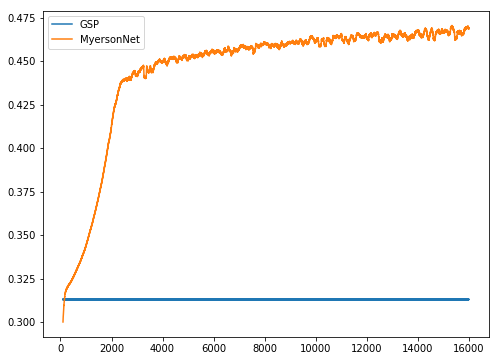

In [23]:
fig, ax = plt.subplots(figsize=(8,6));
ax.plot(gsp_report[['revenue']].rolling(100).mean(), label='GSP');
ax.plot(myerson_net_report[['revenue']].rolling(100).mean(), label='MyersonNet');
ax.legend();